In [2]:
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import os

In [ ]:
cislo_pokusu = "n"
nazev_slozky = f"Pokus_cislo_{cislo_pokusu}"
os.mkdir(f"Pokus_cislo_{cislo_pokusu}")
soubor_poloh_MC = open(f"{nazev_slozky}\\polohy_MC_{cislo_pokusu}.xyz", "a")
soubor_energie_MC = open(f"{nazev_slozky}\\prubeh_en_MC_{cislo_pokusu}.txt", "a")
soubor_prijatych_zmen = open(f"{nazev_slozky}\\prubeh_zmen_MC_{cislo_pokusu}.txt", "a")

pocet_castic = 250
teplota = 170                       # [K]
hmotnost_argonu = 39.948 * 1.66e-27 # [kg]

kb = 1.3806E-23                     # [J*K^-1]
epsilon = 119.8 * kb                # [J]
sigma = 3.41E-10                    # [m]

ro_molarni = 0.14287 * 10**3        #[mol/dm^3] * 10^3 = [mol/m^3]
avogadrova_konst = 6.022E23
ro_ciselna = ro_molarni * avogadrova_konst
objem = pocet_castic / ro_ciselna

velikost_strany_boxu = (objem)**(1/3)
r_cut = 4*sigma
hustota = pocet_castic / objem

### $ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

In [ ]:
def vzdalenost_dvou_casic(poloha_castice_1, poloha_castice_2):
    summa = 0
    for souradnice_c1, souradnice_c2 in zip(poloha_castice_1, poloha_castice_2):
        delta = souradnice_c1 - souradnice_c2
        delta -= round(delta / velikost_strany_boxu) * velikost_strany_boxu
        
        summa += delta ** 2
    return summa # nevracim odmocninu

In [90]:
def generace_nenakladajicich_castic():
    polohy = []
    polohy.append(np.random.uniform(0, velikost_strany_boxu, 3) )
    
    while len(polohy)<pocet_castic:
        nova_castice = np.random.uniform(0, velikost_strany_boxu, 3) 
        
        nakladaji_se = False
        for i in range(len(polohy)):
            if vzdalenost_dvou_casic(nova_castice, polohy[i]) < sigma:
                nakladaji_se = True 
                break
        
        if nakladaji_se == False:
            polohy.append(nova_castice)
        
    return polohy

## LJ potencialni energie paru

### $ U_{r_{ij}} = 4 \epsilon \sum{[ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ]} $

In [ ]:
def LJ_potencialni_energie_castice(abs_vzdal): # upravy pro abs_vzdal^2 
    if abs_vzdal > r_cut**2:
        U_paru = 0
    else:
        U_paru = 4 * epsilon *( (sigma**2/abs_vzdal)**6 - (sigma**2/abs_vzdal)**3 )
    return U_paru

## Celkova potencialni energie 

### $U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [92]:
def celkova_pot_en(polohy):
    U_tot = 0
    for i in range(pocet_castic-1):
        for j in range(i+1, pocet_castic):     
            abs_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[j])
            U_paru = LJ_potencialni_energie_castice(abs_vzdal)
            U_tot += U_paru
    return U_tot

In [1]:
def energie_pot_zvol_cast(polohy, id_castice, pocet_castic):
    U_tot = 0
    for i in range (id_castice):
        abs_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[id_castice])
        U_paru = LJ_potencialni_energie_castice(abs_vzdal)
        U_tot += U_paru        
    for j in range (id_castice+1, pocet_castic):
        abs_vzdal = vzdalenost_dvou_casic(polohy[j], polohy[id_castice])
        U_paru = LJ_potencialni_energie_castice(abs_vzdal)
        U_tot += U_paru
    return U_tot

Nova poloha $\vec{r_{z}^{i}} [\sigma]$  
### $ \vec{r_{z}^{i}} = \vec{r_{i}^{j}} + \vec{u} (- u_{max},  u_{max}) $

In [ ]:
def posunuti(stara_poloha, u_max = 10*sigma): 
    nova_poloha = stara_poloha + np.random.uniform(-u_max, u_max, 3)
    return nova_poloha % velikost_strany_boxu

####  2 Zmena $E_{pot}$ v celem systemu

$\Delta E = E_{nova} - E_{stara} \Rightarrow \Delta E \le 0 ...  \text{prijmame zmeny.}  $

$ \Delta E > 0: \text{prijimame zmeny polohy/hybosti s pravdepodobnosti } P = e^{-\Delta E / (k_B T)} $ kterou poravnavame s nahodnym cislem r, s rovnomernym rozlozenim $r \in [0,1] $

$r<P$ prijmame zmeny (t.z P je blizko 1), $r \ge P$ odmitame

In [94]:
def pravdepodobnostni_kriterium(delta_e):
    return True if delta_e <= 0 or np.random.rand() < np.exp(-delta_e / (kb * teplota)) else False

In [ ]:
# def metropolis_krok(polohy):
    
#     # stara_pot_en = celkova_pot_en(polohy)
#     # print(stara_pot_en)
#     nove_polohy = deepcopy(polohy)
    
#     id_nah_cast = np.random.randint(0,pocet_castic)
#     nove_polohy[id_nah_cast] = posunuti(polohy[id_nah_cast])
    
#     nova_e_pot = celkova_pot_en(nove_polohy)

#     return nove_polohy, 1, nova_e_pot

#     # delta_e_pot = nova_e_pot - stara_pot_en
#     # prijmout_polohy = pravdepodobnostni_kriterium(delta_e_pot)

#     # if prijmout_polohy:
#     #     return nove_polohy, 1, nova_e_pot
#     # else:
#     #     return polohy, 0, stara_pot_en

In [ ]:
def metropolis_krok(polohy):
    stara_pot_en = celkova_pot_en(polohy)
    nove_polohy = deepcopy(polohy)
    
    id_nah_cast = np.random.randint(0,pocet_castic)
    nove_polohy[id_nah_cast] = posunuti(polohy[id_nah_cast])
    
    stara_pot_en = energie_pot_zvol_cast(polohy, id_nah_cast, pocet_castic)    
    nova_e_pot = energie_pot_zvol_cast(nove_polohy, id_nah_cast, pocet_castic)

    delta_e_pot = nova_e_pot - stara_pot_en
    prijmout_polohy = pravdepodobnostni_kriterium(delta_e_pot)

    if prijmout_polohy:
        return nove_polohy, 1, nova_e_pot
    else:
        return polohy, 0, stara_pot_en


### Pocatecni podminky a prubeh

In [96]:
def main():
    polohy = generace_nenakladajicich_castic()
    soubor_poloh_MC.write(f"{pocet_castic}\n \n")
    for castice in polohy:
        soubor_poloh_MC.write("Ar ")
        soubor_poloh_MC.write(" ".join(map(str, castice)) + "\n")      
    
    e_p = [celkova_pot_en(polohy)]
    soubor_energie_MC.write(f"0 {e_p[0]} \n")
    
    prubeh_prijatych_zmen_e_pot = []
    prijate_zmeny_polohy = 0
    
    pocet_kroku_MC = 50
    for i in range(pocet_kroku_MC):
        polohy, co_prijalo, en_pot_n = metropolis_krok(polohy)
        
        prijate_zmeny_polohy+= co_prijalo
        soubor_prijatych_zmen.write(f"{prijate_zmeny_polohy} \n")

        soubor_poloh_MC.write(f"{pocet_castic}\n \n")
        for castice in polohy:
            soubor_poloh_MC.write("Ar ")
            soubor_poloh_MC.write(" ".join(map(str, castice)) + "\n") 
        
        prubeh_prijatych_zmen_e_pot.append(co_prijalo)
        e_p.append(en_pot_n)
        soubor_energie_MC.write(f"{i} {en_pot_n} \n")  
                   
    soubor_energie_MC.close()
    soubor_poloh_MC.close()
    soubor_prijatych_zmen.close()
    
    return prubeh_prijatych_zmen_e_pot, e_p, prijate_zmeny_polohy

In [97]:
prubeh_prijatych_zmen_e_pot, e_p, prijate_zmeny_polohy = main()

In [98]:
soubor_energie_MC.close()
soubor_poloh_MC.close()
soubor_prijatych_zmen.close()

In [99]:
pocet_kroku = 50
zlomek = prijate_zmeny_polohy/pocet_kroku
print(f"zlomek prijeti: {zlomek}")

zlomek prijeti: 1.0


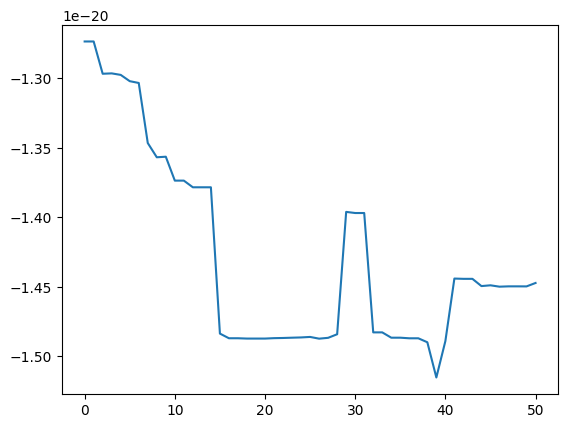

In [100]:
plt.plot(e_p)